# Random seed in node2vec
It seems that seeding of the node2vec is not working properly or needs another approach.

Algorithm uses "random" to shuffle nodes and for making walks from each shuffled node. 

Probably, in the seeded version the algorithm creates the same sequence of nodes over and over again, so the model achieved is poor.  What is proven on "pure data".

(While word2vec and clusterization are seeded.)

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import our code
import seededNode2vec as seededNode2vec
import nonSeededNode2vec as nonSeededNode2vec # same as normal Node2Vec

# from node2vec import Node2Vec

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics

In [4]:
walk_length = 80
num_walks = 10
p = 1.0
q = 1.0
workers = 4

dimensions = 128
window = 10
min_count = 1
seed = 0

In [5]:
# count_embeddings function contains the node2vec's version now 
def count_embeddings(n2vVer,G,labels,dimensions,walk_length,num_walks,p,q,workers,window,min_count,seed):
    n2v = n2vVer.Node2Vec(G, 
               dimensions = dimensions, 
               walk_length = walk_length,
               num_walks = num_walks,
               p = p,
               q = q,
               workers = workers
              )
    model = n2v.fit(window = window, 
                    min_count = min_count,
                    seed = seed
                   )
    model_nodes = list(model.wv.vocab)

    return model,model_nodes
    
def count_score(labels, clusters):
    adj_score = metrics.adjusted_rand_score(labels,clusters)
    return adj_score

In [6]:
def make_graph(labels, edges):
    G = nx.Graph()
    G.add_nodes_from(labels['node'])

    for i, row in edges.iterrows():
        G.add_edge(row['from'],row['to'], weight=1)
    return G

def draw_g(G):
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True, seed=seed)

# 1. SEEDED
## 1.1 One eighth random links
1/8 of nodes are connected with some random ones

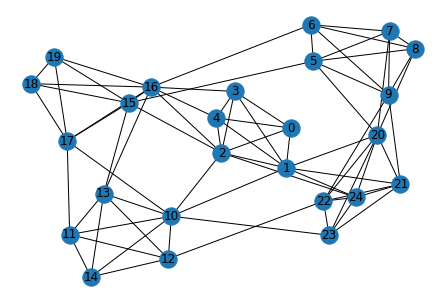

In [7]:
edges = pd.read_csv('../data/clear_cluster_test/one_eighth.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label','label+'))
labels_list = list(labels['label'].unique())
n_clusters = len(labels['label'].unique())

G = make_graph(labels, edges)
draw_g(G)

In [8]:
# first run
model,model_nodes = count_embeddings(seededNode2vec,G,labels,dimensions,
                        walk_length,num_walks,p,q,workers,
                        window,min_count,seed)

known_labels = []
for i in model.wv.index2word:
    known_labels.append(labels.loc[int(i)]['label'])

km = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(model.wv.vectors)
km_map = dict(zip(model.wv.index2word, km))

for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i in km_map:
        if km_map[i] == cluster:
            print(i)

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 1471.44it/s]


cluster:  0
20
5
9
7
6
8
cluster:  1
10
13
11
12
14
cluster:  2
2
1
3
4
0
cluster:  3
16
15
17
19
18
cluster:  4
21
22
24
23


In [9]:
# second run
model2,model2_nodes = count_embeddings(seededNode2vec,G,labels,dimensions,
                        walk_length,num_walks,p,q,workers,
                        window,min_count,seed)

known_labels2 = []
for i in model2.wv.index2word:
    known_labels2.append(labels.loc[int(i)]['label'])

km2 = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(model2.wv.vectors)
km_map2 = dict(zip(model2.wv.index2word, km2))

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 962.08it/s]


In [10]:
# third run
model3,model3_nodes = count_embeddings(seededNode2vec,G,labels,dimensions,
                        walk_length,num_walks,p,q,workers,
                        window,min_count,seed)

known_labels3 = []
for i in model3.wv.index2word:
    known_labels3.append(labels.loc[int(i)]['label'])

km3 = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(model3.wv.vectors)
km_map3 = dict(zip(model3.wv.index2word, km3))

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 1471.77it/s]


__the same values was got__ for the seeded algorithm, but the result is __low__

In [11]:
# adj_rand comparing for 3 runs
print(count_score(known_labels, km) 
      == count_score(known_labels2, km2)
      == count_score(known_labels3, km3)) 

False


In [12]:
# adj_rand
print(count_score(known_labels, km),
      count_score(known_labels2, km2),
      count_score(known_labels3, km3)) 

0.8928571428571429 0.5669014084507042 0.6456692913385828


## 1.2 Pure
on pure data (5 separated groups of 5 nodes) the algorithm should work perfectly, 

but the seeded version of the algo doesn't work

In [13]:
edges_pure = pd.read_csv('../data/clear_cluster_test/pure_edges.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label','label+'))
labels_list = list(labels['label'].unique())
n_clusters = len(labels['label'].unique())

G_pure = make_graph(labels, edges_pure)

In [14]:
model_pure,model_pure_nodes = count_embeddings(seededNode2vec,G_pure,labels,dimensions,
                        walk_length,num_walks,p,q,workers,
                        window,min_count,seed)

known_labels_pure = []
for i in model_pure.wv.index2word:
    known_labels_pure.append(labels.loc[int(i)]['label'])

km_pure = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(model_pure.wv.vectors)
km_map_pure = dict(zip(model_pure.wv.index2word, km_pure))

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 6255.30it/s]


In [15]:
# the score should be equal to 1 for pure data
#adj_rand
print(count_score(known_labels_pure, km_pure)) 

0.03720930232558141


# 2. Non seeded algorithm

## 2.1 One eighth random links
1/8 of nodes are connected with some random one

In [16]:
# first run ------------------------------------------------------------
model_ns,model_nodes_ns = count_embeddings(nonSeededNode2vec,G,labels,dimensions,
                        walk_length,num_walks,p,q,workers,
                        window,min_count,seed)
known_labels_ns = []
for i in model_ns.wv.index2word:
    known_labels_ns.append(labels.loc[int(i)]['label'])
km_ns = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(model_ns.wv.vectors)
km_map_ns = dict(zip(model_ns.wv.index2word, km))

# second run ---------------------------------------------------------
model2_ns,model2_nodes_ns = count_embeddings(nonSeededNode2vec,G,labels,dimensions,
                        walk_length,num_walks,p,q,workers,
                        window,min_count,seed)
known_labels2_ns = []
for i in model2_ns.wv.index2word:
    known_labels2_ns.append(labels.loc[int(i)]['label'])
km2_ns = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(model2_ns.wv.vectors)
km_map2_ns = dict(zip(model2_ns.wv.index2word, km2))

#third run --------------------------------------------------------------------
model3_ns,model3_nodes_ns = count_embeddings(nonSeededNode2vec,G,labels,dimensions,
                        walk_length,num_walks,p,q,workers,
                        window,min_count,seed)
known_labels3_ns = []
for i in model3_ns.wv.index2word:
    known_labels3_ns.append(labels.loc[int(i)]['label'])
km3_ns = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(model3_ns.wv.vectors)
km_map3 = dict(zip(model3_ns.wv.index2word, km3))

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 3126.72it/s]


In [17]:
# f1_micro, adj_rand
print(count_score(known_labels_ns, km_ns) 
      == count_score(known_labels2_ns, km2_ns)
      == count_score(known_labels3_ns, km3_ns)) 

False


In [18]:
#better result for non seeded algo
# f1_micro, adj_rand
print(count_score(known_labels_ns, km_ns),
      count_score(known_labels2_ns, km2_ns),
      count_score(known_labels3_ns, km3_ns)) 

0.5263157894736842 0.5467625899280576 0.5714285714285714


## 2.2 Pure
the non seeded algorithm should works perfectly

In [19]:
model_pure_ns,model_pure_nodes_ns = count_embeddings(nonSeededNode2vec,G_pure,labels,dimensions,
                        walk_length,num_walks,p,q,workers,
                        window,min_count,seed)

known_labels_pure_ns = []
for i in model_pure_ns.wv.index2word:
    known_labels_pure_ns.append(labels.loc[int(i)]['label'])

km_pure_ns = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(model_pure_ns.wv.vectors)
km_map_pure_ns = dict(zip(model_pure_ns.wv.index2word, km_pure))

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 6250.45it/s]


In [20]:
# score = 1, as expected
#adj_rand
print(count_score(known_labels_pure_ns, km_pure_ns)) 

1.0
